In [1]:
# Never do this, but warnings are annoying so I'm blocking them
import warnings
warnings.filterwarnings("ignore")

import keras.layers  as  klayers 
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Input, Embedding, GlobalAveragePooling1D, Concatenate, Activation, Lambda, BatchNormalization, Convolution1D, Dropout, merge
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import initializers
from keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from keras.activations import relu
from keras.backend import reshape

import numpy as np
import nltk

import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from skll.metrics import kappa
from scipy import stats

from datetime import datetime

# Import custom NEA layers
from nea import Attention, MeanOverTime, Conv1DWithMasking
from ats import Temporal_Mean_Pooling, Neural_Tensor_layer

from essaysenseOther import load_asap, load_glove
from essaysenseUtils import ASAPDataSet, SentenceLevelTestSet

from customUtils import preprocess_asap, get_optimizer, limits

Using TensorFlow backend.


In [2]:
class NEA_HyperParameters:
    def __init__(self):
        self.method='lstm'     # gru, rnn, lstm
        self.optimizer='adam'  # def: adam
        self.aggregation='tmp' # tmp (ATS), mot (NEA), attsum, attmean, or nothing
        self.dropout_prob=0    # def: 0.5; '0' for no dropout
        self.cnn_dim=300       # '0' mean no CNN layer
        self.rnn_dim=300
        self.cnn_window_size=3 # def: 3
        self.dropout_W = 0.5
        self.dropout_U = 0.1   
        self.cnn_border_mode='same' 
        self.activation="relu"
        self.maxlen=500        # TAKEN FROM ATSUTILS.PY
        self.seed=1024
nea_hp = NEA_HyperParameters()

In [3]:
class EssaySense_HyperParameters:
    def __init__(self):
        self.train_epochs = 700  # General training epochs.
        self.w_dim = 50          # Word embedding dimension.
        self.s_len = 20          # Sentence length in the sentence-level models.
        self.e_len = 60          # Essay length in the sentence-level models.
        self.w_window_len = 5    # Convolution window size of word level.
        self.s_window_len = 3    # Convolution window size of sentence level.
        self.w_convunits_size = 64 # Convolution unit number of word level.
        self.s_convunits_size = 32 # Convolution unit number of sentence level.
        self.hidden_size = 100     # Dense layer size of sentence-level models.
        self.batch_size = 20       # Batch size.
        self.learning_rate = 0.006 # Initial learning rate.
        self.dropout_keep_prob = 0.3       # Dropout rate.
        self.lstm_hidden_size = 150        # Dense layer size of LSTM models.
        self.cnn_lstm_convunits_size = 80  # Conv units of CNN-LSTM models.
        self.cnn_lstm_att_pool_size = 50   # Attention pool size.
es_hp = EssaySense_HyperParameters()

In [4]:
prompt = '2'
VALIDATION_SPLIT=0.30
TEST_SPLIT=0.50
range_max, range_min = limits(prompt)
glove_dir = "glove.6B.300d.txt"
data_dir = "data/training_set.tsv"

Min Score: 1.0 | Max Score: 6.0


In [5]:
# NEA PREPROCESSING
x_train, y_train, x_val, y_val, x_test, y_test, embedding_layer = preprocess_asap(prompt,VALIDATION_SPLIT,TEST_SPLIT, glove_dir, data_dir)

Processing GloVe embedding...
Embedding done!
Min Score: 1.0 | Max Score: 6.0
Number of Training Essays: 1800
Found 14685 unique tokens!
Shape of data tensor: (1800, 500)
Splitting training/test data...
Done.


In [6]:
# ESSAYSENSE PREPROCESSING
glove_table = load_glove(es_hp, glove_dir)
asap_train = load_asap(domain_id=prompt)

asap_processed = SentenceLevelTestSet(
    hyperparameters=es_hp,
    lookup_table=glove_table,
    raw_test_set=asap_train)
train_essays, train_scores = asap_processed.all()

indices=np.arange(train_essays.shape[0])
np.random.shuffle(indices)
train_essays=train_essays[indices]
train_scores=train_scores[indices]
validation_size=int(VALIDATION_SPLIT*train_essays.shape[0])

x_train=train_essays[:-validation_size]
y_train=train_scores[:-validation_size]
x_notrain=train_essays[-validation_size:]
y_notrain=train_scores[-validation_size:]

test_size=int(TEST_SPLIT*x_notrain.shape[0])
x_val=x_notrain[:-test_size]
y_val=y_notrain[:-test_size]
x_test=x_notrain[-test_size:]
y_test=y_notrain[-test_size:]

[Loading] ASAP-AES domain 1 dataset...


# Neural Models

In [13]:
# Bi-directional LSTM
def BLSTM(hp):    
    # Embedding Layer
    e = Input(name='essay',shape=(hp.maxlen,))
    embed = embedding_layer(e)
    
    # BLSTM Layer
    if hp.rnn_dim > 0:
        forwards = LSTM(hp.rnn_dim, return_sequences=True, dropout_W=hp.dropout_W, dropout_U=hp.dropout_U)(embed)
        backwards = LSTM(hp.rnn_dim, return_sequences=True, dropout_W=hp.dropout_W, dropout_U=hp.dropout_U, go_backwards=True)(embed)
    if hp.dropout_prob > 0:
        forwards = Dropout(hp.dropout_prob)(forwards)
        backwards = Dropout(hp.dropout_prob)(backwards)
    forwards_mean = MeanOverTime(mask_zero=True)(forwards)
    backwards_mean = MeanOverTime(mask_zero=True)(backwards)
    merged = merge([forwards_mean, backwards_mean], mode='concat', concat_axis=-1)
    drop = Dense(num_outputs)(merged)
    
    # Optional Dropout Layer
    if hp.dropout_prob > 0:
        drop=Dropout(hp.dropout_prob)(hidden_states)
    else:
        drop=hidden_states
    
    # Aggregation Methods
    if hp.aggregation == 'mot':
        htm=MeanOverTime(mask_zero=True)(drop)
    elif hp.aggregation == 'tmp':
        htm=Temporal_Mean_Pooling()(drop)
    elif hp.aggregation.startswith('att'):
        htm=Attention(op=hp.aggregation, activation='tanh', init_stdev=0.01)(drop)
    
    # Connected Hidden Layer
    dense = Dense(256, activation=hp.activation,kernel_initializer=initializers.glorot_normal(seed=hp.seed))(htm)
    dense = Dense(128, activation=hp.activation,kernel_initializer=initializers.glorot_normal(seed=hp.seed))(dense)
    dense = Dense(64, activation=hp.activation,kernel_initializer=initializers.glorot_normal(seed=hp.seed))(dense)
    out = Dense(1, activation="sigmoid")(dense)
    
    # Model Compiler
    model = Model(inputs=[e], outputs=[out])
    model.compile(loss="mean_squared_error", optimizer=get_optimizer(hp.optimizer), metrics=["MSE"])
    return model

In [3]:
# NEA-based Networks
def nea(hp, embedding_layer):
    # Debug Outputs
    print('RNN: %s | CNN: %s | Agg: %s' % (hp.method, hp.cnn_dim, hp.aggregation))
    
    # Embedding Layer
    e = Input(name='essay',shape=(hp.maxlen,))
    embed = embedding_layer(e)

    # Optional Convolutional Layer
    if hp.cnn_dim > 0:
        cnn_layer=Conv1DWithMasking(nb_filter=hp.cnn_dim, filter_length=hp.cnn_window_size, border_mode=hp.cnn_border_mode, subsample_length=1)(embed)
        embed=cnn_layer
    
    # Network Layer
    if hp.method == 'lstm': # Typically uses 'tmp' aggregation method
        lstm_layer=LSTM(hp.rnn_dim,return_sequences=True) 
        hidden_states=lstm_layer(embed)
    elif hp.method == 'rnn': 
        rnn_layer=SimpleRNN(hp.rnn_dim, return_sequences=True, dropout_W=hp.dropout_W, dropout_U=hp.dropout_U)
        hidden_states=rnn_layer(embed)
    elif hp.method == 'gru': 
        rnn_layer=GRU(hp.rnn_dim, return_sequences=True, dropout_W=hp.dropout_W, dropout_U=hp.dropout_U)
        hidden_states=rnn_layer(embed)
        
    # Optional Dropout Layer
    if hp.dropout_prob > 0:
        drop=Dropout(hp.dropout_prob)(hidden_states)
    else:
        drop=hidden_states
    
    # Aggregation Methods
    if hp.aggregation == 'mot':
        htm=MeanOverTime(mask_zero=True)(drop)
    elif hp.aggregation == 'tmp':
        htm=Temporal_Mean_Pooling()(drop)
    elif hp.aggregation.startswith('att'):
        htm=Attention(op=hp.aggregation, activation='tanh', init_stdev=0.01)(drop)
    
    # Connected Hidden Layer
    dense = Dense(256, activation=hp.activation,kernel_initializer=initializers.glorot_normal(seed=hp.seed))(htm)
    dense = Dense(128, activation=hp.activation,kernel_initializer=initializers.glorot_normal(seed=hp.seed))(dense)
    dense = Dense(64, activation=hp.activation,kernel_initializer=initializers.glorot_normal(seed=hp.seed))(dense)
    out = Dense(1, activation="sigmoid")(dense)
    
    # Model Compiler
    model = Model(inputs=[e], outputs=[out])
    model.compile(loss="mean_squared_error", optimizer=get_optimizer(hp.optimizer), metrics=["MSE"])
    return model

In [7]:
def essaysense_cnn_lstm(hp):
    optimizer = 'adam'
    
    essays = Input(name='essays',shape=(hp.e_len, hp.s_len, hp.w_dim))
    
    # Convolutional layer
    conv1 = Conv2d(filters=cnn_lstm_convunits_size, kernel_size=[1, w_window_len], padding="same", activation=tf.nn.relu)(essays)

    # Attention pooling
    att1_mat = tf.Variable(tf.truncated_normal([cnn_lstm_convunits_size, cnn_lstm_convunits_size]), dtype=tf.float32)
    att1_bias = tf.Variable(tf.truncated_normal([1, 1, 1, cnn_lstm_convunits_size]),dtype=tf.float32)
    att1_weight = tf.tensordot(conv1, att1_mat, axes=[3, 0]) + att1_bias
    att1_weight = tf.nn.tanh(att1_weight)
    att1_vec = tf.Variable(tf.truncated_normal([cnn_lstm_convunits_size, 1]), dtype=tf.float32)
    att1_weight = tf.tensordot(att1_weight, att1_vec, axes=[3, 0])
    att1_weight = tf.nn.softmax(att1_weight, dim=2)
    att1_output = att1_weight * conv1
    att1_output = tf.reduce_sum(att1_output, axis=2)

    # Long Short-Term Memory layer
    lstm_cell = tfrnn.BasicLSTMCell(num_units=cnn_lstm_att_pool_size)
    lstm_cell = tfrnn.DropoutWrapper(cell=lstm_cell, output_keep_prob=dropout_keep_prob)
    init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
    lstm, _ = tf.nn.dynamic_rnn(lstm_cell, att1_output, dtype=tf.float32)

    # Attention pooling
    att2_mat = tf.Variable(tf.truncated_normal([cnn_lstm_att_pool_size,cnn_lstm_att_pool_size]), dtype=tf.float32)
    att2_bias = tf.Variable(tf.truncated_normal([1, 1, cnn_lstm_att_pool_size]), dtype=tf.float32)
    att2_weight = tf.tensordot(lstm, att2_mat, axes=[2, 0])
    att2_weight = tf.nn.tanh(att2_weight)
    att2_vec = tf.Variable(tf.truncated_normal([cnn_lstm_att_pool_size, 1]), dtype=tf.float32)
    att2_weight = tf.tensordot(att2_weight, att2_vec, axes=[2, 0])
    att2_weight = tf.nn.softmax(att2_weight, dim=1)
    att2_output = att2_weight * lstm
    att2_output = tf.reduce_sum(att2_output, axis=1)

    # Dense layer
    out = Dense(1, activation="sigmoid")(att2_output)

    # Model Compiler
    model = Model(inputs=[essays], outputs=[out])
    model.compile(loss="mean_squared_error", optimizer=get_optimizer(optimizer), metrics=["MSE"])
    return model

In [8]:
def essaysense_cnn_cnn(hp):    
    optimizer = 'adam'
    
    essays = Input(name='essays',shape=(hp.e_len, hp.s_len, hp.w_dim))
    
    # Convolutional layer 1
    conv1 = Conv2D(filters=hp.w_convunits_size,kernel_size=[1, hp.w_window_len],padding="same",activation=None)(essays)
    bn1 = BatchNormalization()(conv1)
    activated1 = bn1 # activated1 = relu(bn1)
    pool1 = MaxPooling2D(pool_size=[1, hp.s_len], strides=1)(activated1)
    
    # Convolutional layer 2
    conv2 = Conv2D(filters=hp.s_convunits_size,kernel_size=[hp.s_window_len, 1],padding="same",activation=None)(pool1)
    bn2 = BatchNormalization()(conv2)
    activated2 = bn2 # activated2 = relu(bn2)
    pool2 = MaxPooling2D(pool_size=[hp.e_len, 1], strides=1)(activated2)
    pool2_flat = Flatten()(pool2) # pool2_flat = reshape(pool2, [-1, hp.s_convunits_size])
    
    # Dense layers
    dense1 = Dense(hp.hidden_size, activation="relu")(pool2_flat)
    out = Dense(1, activation="sigmoid")(dense1)

    # Model Compiler
    model = Model(inputs=[essays], outputs=[out])
    model.compile(loss="mean_squared_error", optimizer=get_optimizer(optimizer), metrics=["MSE"])
    return model

In [20]:
# sf_1 = essaysense_cnn_cnn()
sf_1 = nea()

RNN: lstm | CNN: 300 | Agg: tmp


In [21]:
earlystopping = EarlyStopping(monitor="val_MSE", patience=5)
hist = sf_1.fit([x_train], y_train, batch_size=20, epochs=100,
                validation_data=([x_val], y_val), callbacks=[earlystopping])

Train on 1260 samples, validate on 270 samples
Epoch 1/100
  60/1260 [>.............................] - ETA: 1:23 - loss: 0.0270 - MSE: 0.0270

KeyboardInterrupt: 

In [12]:
# BHKappa Evaluation
y_pred=sf_1.predict([x_test])
y_val_fin = [int(round(a*(range_max-range_min)+range_min)) for a in y_test]
y_pred_fin =[int(round(a*(range_max-range_min)+range_min)) for a in y_pred.reshape(x_test.shape[0]).tolist()]
print(cohen_kappa_score(y_val_fin,y_pred_fin,weights="quadratic"))

0.23443742750354424


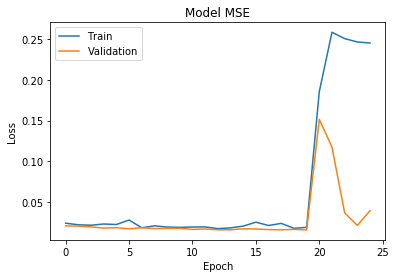

In [10]:
# Plot training & validation loss values
plt.plot(hist.history['MSE'])
plt.plot(hist.history['val_MSE'])
plt.title('Model MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [4]:
def pipeline(testID, method, cnn):
    VALIDATION_SPLIT=0.30
    TEST_SPLIT=0.50
    glove_dir = "glove.6B.300d.txt"
    data_dir = "data/training_set.tsv"
    earlystopping = EarlyStopping(monitor="val_MSE", patience=10)

    # Results File
    results = open("models/%s_Results.txt" % testID, "w+")
    print("Model: %s" % testID)
    t0 = datetime.now()
    
    # Configure Hyperparameters
    nea_hp.method = method
    if cnn:
        nea_hp.cnn_dim = 300
    else:
        nea_hp.cnn_dim = 0

    # Pipeline to evaluate all prompts
    for prompt in range(8):
        prompt = str(prompt+1) # Ad-hoc because I'm a bad programmer
        print("Prompt: %s" % prompt)
        range_max, range_min = limits(prompt)
        
        for fold in range(5):
            fold = str(fold+1)
            print("Fold %s" % fold)
            
            # Model Training
            x_train, y_train, x_val, y_val, x_test, y_test, embedding_layer = preprocess_asap(prompt,VALIDATION_SPLIT,TEST_SPLIT, glove_dir, data_dir)
            sf_1 = nea(nea_hp, embedding_layer)
            hist = sf_1.fit([x_train], y_train, batch_size=20, epochs=100, validation_data=([x_val], y_val), callbacks=[earlystopping])

            # BHKappa Evaluation
            y_pred=sf_1.predict([x_test])
            y_val_fin = [int(round(a*(range_max-range_min)+range_min)) for a in y_test]
            y_pred_fin =[int(round(a*(range_max-range_min)+range_min)) for a in y_pred.reshape(x_test.shape[0]).tolist()]
            score = cohen_kappa_score(y_val_fin, y_pred_fin, weights="quadratic")
            results.write("%s \n" % score)
            print("QWK, Prompt %s, Fold %s: %s" % (prompt, fold, score))
            
            # Plot training & validation loss values
            plt.plot(hist.history['f%s MSE' % fold])
            plt.plot(hist.history['f%s val_MSE'])
            plt.title('Model %s, Essay %s MSE' % (testID, prompt))
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['Train', 'Validation'], loc='upper left')
            plt.savefig('models/graphs/%s_%s.png' % (testID, prompt))

            # Save Model Weights (Eh)
            # sf_1.save('models/%s_%s_model.h5' % (testID, prompt))
            # sf_1.save_weights('models/%s_%s_weights.h5' % (testID, prompt))
        results.write("\n ---- \n")
        plt.clf()
    results.close()

    t1 = datetime.now()
    print('Processing time: {}'.format(t1 - t0))

In [ ]:
pipeline('LSTM_CNN','lstm',1)
pipeline('LSTM','lstm',0)
pipeline('RNN_CNN','rnn',1)
pipeline('RNN','rnn',0)
pipeline('GRU_CNN','gru',1)
pipeline('GRU','gru',0)

Model: LSTM_CNN
Prompt: 1
Min Score: 2.0 | Max Score: 12.0
Fold 1
Processing GloVe embedding...
Embedding done!
Min Score: 2.0 | Max Score: 12.0
Number of Training Essays: 1783
Found 16200 unique tokens!
Shape of data tensor: (1783, 500)
Splitting training/test data...
Done.
RNN: lstm | CNN: 300 | Agg: tmp
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1249 samples, validate on 267 samples
Epoch 1/100
1249/1249 [==============================] - 42s 34ms/step - loss: 0.0242 - MSE: 0.0242 - val_loss: 0.0258 - val_MSE: 0.0258
Epoch 2/100
1249/1249 [==============================] - 42s 33ms/step - loss: 0.0189 - MSE: 0.0189 - val_loss: 0.0189 - val_MSE: 0.0189
Epoch 3/100
1249/1249 [==============================] - 42s 34ms/step - loss: 0.0171 - MSE: 0.0171 - val_loss: 0.0217 - val_MSE: 0.0217
Epoch 4/100
1249/1249 [==============================] - 44s 35ms/step - loss: 0.0206 - MSE: 0.0206 - val_loss: 0.0234 - val_MSE: 0.0234
Ep